In [14]:
import torch
import torch.nn as nn
import torch.nn.functional
import torch_geometric.nn 
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
import numpy as np
import tqdm
import random
from torch_geometric.nn import GATConv, global_mean_pool
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader


In [15]:
pkl_graphs = pd.read_pickle('/Users/MathildeStouby/Desktop/P5 GitHub/5-semester/Momentum graphs.pkl')

In [16]:
unique_nodes = []
for graph in pkl_graphs.values():
    temp = [node for node in graph.nodes() if node not in unique_nodes]
    unique_nodes.extend(temp)

In [17]:
idx_to_pos = dict(enumerate(unique_nodes))
pos_to_idx = {pos : idx for idx, pos in idx_to_pos.items()}

In [18]:
pyg_data = []
thors_kamp = []


for idx, graph in pkl_graphs.items():

    closeness = nx.closeness_centrality(graph)
    betweenness = nx.closeness_centrality(graph)
    pagerank = nx.pagerank(graph, weight='weight')
    centrality_list = [closeness, betweenness, pagerank] 

    #adj_dict = nx.to_dict_of_dicts(graph)

    for node in list(graph.nodes()):
        #adj_vect = np.zeros((len(unique_nodes)))
        #players = adj_dict[node]
        #for key, value in players.items():
            #adj_vect[pos_to_idx[key]] = value['weight']
        #adj_vect = torch.from_numpy(adj_vect).float()
        centrality_vect = []
        for measure in centrality_list:
            if node in list(measure.keys()):
                centrality_vect.append(measure[node])
            else:
                centrality_vect.append(0)
        centrality_vect = torch.Tensor(centrality_vect).float()        
        #graph.nodes[node]['x'] = torch.cat((adj_vect, centrality_vect), -1)
        graph.nodes[node]['x'] = centrality_vect

   
    for node in unique_nodes:
        if node not in graph.nodes:
            graph.add_node(node) 
            #graph.nodes[node]['x'] = torch.from_numpy(np.zeros((len(unique_nodes)+3))).float()
            graph.nodes[node]['x'] = torch.from_numpy(np.zeros(3)).float()  
            

    data = from_networkx(graph)

    try:
        data['momentum']
        if idx.startswith('3895275'):
            thors_kamp.append(data)
        else:
            pyg_data.append(data)
    except:
        print(data)


Data(x=[23, 3], edge_index=[2, 22], weight=[22])


In [19]:
train_idx = random.sample(range(len(pyg_data)), int(len(pyg_data) * 0.8))
test_idx = [i for i in range(len(pyg_data)) if i not in train_idx]

In [20]:
train_data = [pyg_data[idx] for idx in train_idx]
dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

In [21]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1= GATConv(input_dim, hidden_dim, heads=num_heads, edge_dim=1)
        self.layer2= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
        #self.layer3= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
        #self.layer4= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.layer5 = GATConv(hidden_dim * num_heads, output_dim, heads=1, edge_dim=1, concat=False)
        self.activation_function = nn.ReLU()
     

    def forward(self, input, edge_index, edge_attr, batch):
        output = self.activation_function(self.layer1(input, edge_index, edge_attr))
        output = self.activation_function(self.layer2(output, edge_index, edge_attr))
        output = self.layer5(output, edge_index, edge_attr)
        output = global_mean_pool(output, batch)
        return output

In [22]:
#input_dim = len(unique_nodes)+3
input_dim = 3
lr = 0.01

gat = GAT(input_dim = input_dim, hidden_dim = 11, output_dim = 1, num_heads = 6)
optimizer = torch.optim.SGD(gat.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
epochs_num = 100

In [23]:
for epoch in tqdm.tqdm(range(epochs_num)):
    
    epoch_loss = 0
    for batch in tqdm.tqdm(dataloader):
        # Forward pass
        optimizer.zero_grad()
        
        output = gat(batch.x, batch.edge_index, batch.weight, batch.batch)
        
        # Calculate loss
        loss = loss_fn(output, batch.momentum)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}") 
gat.eval() 

  0%|          | 0/100 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:24,  4.12it/s]

Epoch 1, Loss: 0.0069


  2%|▏         | 2/100 [00:00<00:17,  5.76it/s]

Epoch 2, Loss: 0.0069


  3%|▎         | 3/100 [00:00<00:14,  6.54it/s]

Epoch 3, Loss: 0.0068


  4%|▍         | 4/100 [00:00<00:14,  6.52it/s]

Epoch 4, Loss: 0.0069


  5%|▌         | 5/100 [00:00<00:14,  6.65it/s]

Epoch 5, Loss: 0.0070


  6%|▌         | 6/100 [00:00<00:12,  7.24it/s]

Epoch 6, Loss: 0.0067


  7%|▋         | 7/100 [00:01<00:12,  7.44it/s]

Epoch 7, Loss: 0.0067


  8%|▊         | 8/100 [00:01<00:11,  7.73it/s]

Epoch 8, Loss: 0.0068


  9%|▉         | 9/100 [00:01<00:11,  7.99it/s]

Epoch 9, Loss: 0.0069


 10%|█         | 10/100 [00:01<00:10,  8.23it/s]

Epoch 10, Loss: 0.0068


 11%|█         | 11/100 [00:01<00:11,  7.74it/s]

Epoch 11, Loss: 0.0070


 12%|█▏        | 12/100 [00:01<00:10,  8.10it/s]

Epoch 12, Loss: 0.0067


 13%|█▎        | 13/100 [00:01<00:10,  8.15it/s]

Epoch 13, Loss: 0.0067


 14%|█▍        | 14/100 [00:01<00:10,  8.10it/s]

Epoch 14, Loss: 0.0068


 15%|█▌        | 15/100 [00:02<00:10,  8.32it/s]

Epoch 15, Loss: 0.0068


 16%|█▌        | 16/100 [00:02<00:10,  7.82it/s]

Epoch 16, Loss: 0.0068


 17%|█▋        | 17/100 [00:02<00:10,  8.08it/s]

Epoch 17, Loss: 0.0066


 18%|█▊        | 18/100 [00:02<00:10,  8.19it/s]

Epoch 18, Loss: 0.0067


 19%|█▉        | 19/100 [00:02<00:09,  8.29it/s]

Epoch 19, Loss: 0.0067


 20%|██        | 20/100 [00:02<00:10,  7.86it/s]

Epoch 20, Loss: 0.0068


 21%|██        | 21/100 [00:02<00:11,  7.05it/s]

Epoch 21, Loss: 0.0067


 22%|██▏       | 22/100 [00:02<00:10,  7.49it/s]

Epoch 22, Loss: 0.0068


 23%|██▎       | 23/100 [00:03<00:10,  7.65it/s]

Epoch 23, Loss: 0.0068


 24%|██▍       | 24/100 [00:03<00:12,  6.22it/s]

Epoch 24, Loss: 0.0068


 25%|██▌       | 25/100 [00:03<00:11,  6.46it/s]

Epoch 25, Loss: 0.0069


 26%|██▌       | 26/100 [00:03<00:11,  6.38it/s]

Epoch 26, Loss: 0.0067


 27%|██▋       | 27/100 [00:03<00:10,  6.89it/s]

Epoch 27, Loss: 0.0067


 28%|██▊       | 28/100 [00:03<00:10,  7.10it/s]

Epoch 28, Loss: 0.0069


 29%|██▉       | 29/100 [00:03<00:09,  7.25it/s]

Epoch 29, Loss: 0.0067


 30%|███       | 30/100 [00:04<00:09,  7.01it/s]

Epoch 30, Loss: 0.0068


 31%|███       | 31/100 [00:04<00:09,  7.48it/s]

Epoch 31, Loss: 0.0068


 32%|███▏      | 32/100 [00:04<00:09,  7.55it/s]

Epoch 32, Loss: 0.0070


 33%|███▎      | 33/100 [00:04<00:08,  7.50it/s]

Epoch 33, Loss: 0.0067


 34%|███▍      | 34/100 [00:04<00:09,  7.33it/s]

Epoch 34, Loss: 0.0067


 35%|███▌      | 35/100 [00:04<00:08,  7.49it/s]

Epoch 35, Loss: 0.0067


 36%|███▌      | 36/100 [00:04<00:08,  7.22it/s]

Epoch 36, Loss: 0.0068


 37%|███▋      | 37/100 [00:05<00:08,  7.64it/s]

Epoch 37, Loss: 0.0069


 38%|███▊      | 38/100 [00:05<00:08,  7.19it/s]

Epoch 38, Loss: 0.0067


 39%|███▉      | 39/100 [00:05<00:08,  7.33it/s]

Epoch 39, Loss: 0.0066


 40%|████      | 40/100 [00:05<00:08,  7.39it/s]

Epoch 40, Loss: 0.0067


 41%|████      | 41/100 [00:05<00:07,  7.59it/s]

Epoch 41, Loss: 0.0067


 42%|████▏     | 42/100 [00:05<00:07,  7.29it/s]

Epoch 42, Loss: 0.0070


 43%|████▎     | 43/100 [00:05<00:07,  7.42it/s]

Epoch 43, Loss: 0.0067


 44%|████▍     | 44/100 [00:05<00:07,  7.67it/s]

Epoch 44, Loss: 0.0066


 45%|████▌     | 45/100 [00:06<00:07,  7.67it/s]

Epoch 45, Loss: 0.0068


 46%|████▌     | 46/100 [00:06<00:07,  7.13it/s]

Epoch 46, Loss: 0.0068


 47%|████▋     | 47/100 [00:06<00:07,  7.37it/s]

Epoch 47, Loss: 0.0066


 48%|████▊     | 48/100 [00:06<00:07,  7.41it/s]

Epoch 48, Loss: 0.0068


 49%|████▉     | 49/100 [00:06<00:06,  7.62it/s]

Epoch 49, Loss: 0.0067


 50%|█████     | 50/100 [00:06<00:07,  7.13it/s]

Epoch 50, Loss: 0.0068


 51%|█████     | 51/100 [00:06<00:06,  7.18it/s]

Epoch 51, Loss: 0.0067


 52%|█████▏    | 52/100 [00:07<00:06,  7.28it/s]

Epoch 52, Loss: 0.0067


 53%|█████▎    | 53/100 [00:07<00:06,  7.56it/s]

Epoch 53, Loss: 0.0068


 54%|█████▍    | 54/100 [00:07<00:06,  7.12it/s]

Epoch 54, Loss: 0.0066


 55%|█████▌    | 55/100 [00:07<00:06,  7.36it/s]

Epoch 55, Loss: 0.0066


 56%|█████▌    | 56/100 [00:07<00:05,  7.75it/s]

Epoch 56, Loss: 0.0068


 57%|█████▋    | 57/100 [00:07<00:05,  7.80it/s]

Epoch 57, Loss: 0.0067


 58%|█████▊    | 58/100 [00:07<00:05,  7.34it/s]

Epoch 58, Loss: 0.0068


 59%|█████▉    | 59/100 [00:08<00:05,  7.39it/s]

Epoch 59, Loss: 0.0068


 60%|██████    | 60/100 [00:08<00:05,  7.29it/s]

Epoch 60, Loss: 0.0068


 61%|██████    | 61/100 [00:08<00:05,  7.31it/s]

Epoch 61, Loss: 0.0069


 62%|██████▏   | 62/100 [00:08<00:05,  6.94it/s]

Epoch 62, Loss: 0.0069


 63%|██████▎   | 63/100 [00:08<00:05,  7.08it/s]

Epoch 63, Loss: 0.0068


 64%|██████▍   | 64/100 [00:08<00:04,  7.33it/s]

Epoch 64, Loss: 0.0067


 65%|██████▌   | 65/100 [00:08<00:04,  7.54it/s]

Epoch 65, Loss: 0.0067


 66%|██████▌   | 66/100 [00:08<00:04,  7.18it/s]

Epoch 66, Loss: 0.0067


 67%|██████▋   | 67/100 [00:09<00:04,  7.56it/s]

Epoch 67, Loss: 0.0068


 68%|██████▊   | 68/100 [00:09<00:04,  7.67it/s]

Epoch 68, Loss: 0.0068


 69%|██████▉   | 69/100 [00:09<00:04,  7.63it/s]

Epoch 69, Loss: 0.0068


 70%|███████   | 70/100 [00:09<00:04,  7.22it/s]

Epoch 70, Loss: 0.0068


 71%|███████   | 71/100 [00:09<00:03,  7.49it/s]

Epoch 71, Loss: 0.0067


 72%|███████▏  | 72/100 [00:09<00:03,  7.55it/s]

Epoch 72, Loss: 0.0068


 73%|███████▎  | 73/100 [00:09<00:03,  7.77it/s]

Epoch 73, Loss: 0.0067


 74%|███████▍  | 74/100 [00:10<00:03,  7.38it/s]

Epoch 74, Loss: 0.0067


 75%|███████▌  | 75/100 [00:10<00:03,  7.35it/s]

Epoch 75, Loss: 0.0067


 76%|███████▌  | 76/100 [00:10<00:03,  7.48it/s]

Epoch 76, Loss: 0.0070


 77%|███████▋  | 77/100 [00:10<00:03,  7.60it/s]

Epoch 77, Loss: 0.0067


 78%|███████▊  | 78/100 [00:10<00:03,  7.15it/s]

Epoch 78, Loss: 0.0067


 79%|███████▉  | 79/100 [00:10<00:02,  7.54it/s]

Epoch 79, Loss: 0.0071


 80%|████████  | 80/100 [00:10<00:02,  7.68it/s]

Epoch 80, Loss: 0.0069


 81%|████████  | 81/100 [00:10<00:02,  7.91it/s]

Epoch 81, Loss: 0.0067


 82%|████████▏ | 82/100 [00:11<00:02,  7.40it/s]

Epoch 82, Loss: 0.0068


 83%|████████▎ | 83/100 [00:11<00:02,  7.35it/s]

Epoch 83, Loss: 0.0067


 84%|████████▍ | 84/100 [00:11<00:02,  7.45it/s]

Epoch 84, Loss: 0.0068


 85%|████████▌ | 85/100 [00:11<00:01,  7.54it/s]

Epoch 85, Loss: 0.0069


 86%|████████▌ | 86/100 [00:11<00:02,  6.97it/s]

Epoch 86, Loss: 0.0067


 87%|████████▋ | 87/100 [00:11<00:01,  7.32it/s]

Epoch 87, Loss: 0.0067


 88%|████████▊ | 88/100 [00:11<00:01,  7.50it/s]

Epoch 88, Loss: 0.0067


 89%|████████▉ | 89/100 [00:12<00:01,  7.52it/s]

Epoch 89, Loss: 0.0066


 90%|█████████ | 90/100 [00:12<00:01,  7.12it/s]

Epoch 90, Loss: 0.0067


 91%|█████████ | 91/100 [00:12<00:01,  7.25it/s]

Epoch 91, Loss: 0.0067


 92%|█████████▏| 92/100 [00:12<00:01,  7.39it/s]

Epoch 92, Loss: 0.0067


 93%|█████████▎| 93/100 [00:12<00:00,  7.20it/s]

Epoch 93, Loss: 0.0067


 94%|█████████▍| 94/100 [00:12<00:00,  7.25it/s]

Epoch 94, Loss: 0.0067


 95%|█████████▌| 95/100 [00:12<00:00,  7.41it/s]

Epoch 95, Loss: 0.0066


 96%|█████████▌| 96/100 [00:13<00:00,  6.83it/s]

Epoch 96, Loss: 0.0068


 97%|█████████▋| 97/100 [00:13<00:00,  7.01it/s]

Epoch 97, Loss: 0.0068


 98%|█████████▊| 98/100 [00:13<00:00,  6.51it/s]

Epoch 98, Loss: 0.0068


 99%|█████████▉| 99/100 [00:13<00:00,  6.77it/s]

Epoch 99, Loss: 0.0066


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]

Epoch 100, Loss: 0.0067


GAT(
  (layer1): GATConv(3, 11, heads=6)
  (layer2): GATConv(66, 11, heads=6)
  (layer5): GATConv(66, 1, heads=1)
  (activation_function): ReLU()
)

In [24]:
y_pred  = []
y_true = []

with torch.no_grad():
    for idx in test_idx:
        batch = torch.zeros(pyg_data[idx].x.size(0), dtype=torch.long)
        output = gat(pyg_data[idx].x, pyg_data[idx].edge_index, pyg_data[idx].weight, batch)
        y_pred.append(output.item())
        y_true.append(pyg_data[idx].momentum)
        
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.050088483910331605

In [25]:
y_pred  = []
y_true = []
batch = torch.zeros(23, dtype=torch.long)


with torch.no_grad():
    for graph in thors_kamp:
        output = gat(graph.x, graph.edge_index, graph.weight, batch)
        y_pred.append(output.item())
        y_true.append(graph.momentum)


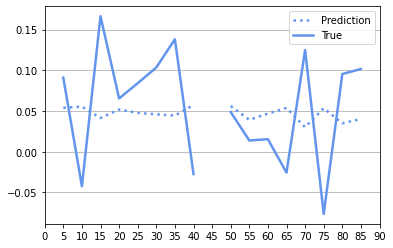

In [26]:
y_pred  = []
y_true = []
batch = torch.zeros(23, dtype=torch.long)

with torch.no_grad():
    for graph in thors_kamp:
        output = gat(graph.x, graph.edge_index, graph.weight, batch)
        y_pred.append(output.item())
        y_true.append(graph.momentum)

x= list(range(5, 90, 5))
x.remove(45)

import matplotlib.pyplot as plt

ax = plt.axes()        
ax.yaxis.grid() 
plt.plot(x[0:8], y_pred[0:8], linestyle = 'dotted', color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[0:8], y_true[0:8], color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[8:16], y_pred[8:16], linestyle = 'dotted', color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[8:16], y_true[8:16], color = 'cornflowerblue', linewidth = '2.5')
plt.legend(["Prediction", "True"], loc="upper right")
x_ticks = list(range(0, 95, 5))
plt.xticks(ticks=x_ticks,)

plt.savefig('predictions.pdf', bbox_inches='tight')